<a href="https://colab.research.google.com/github/manuelurgell/TC4034.10-Equipo18/blob/main/proyecto_avance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introducción**

Utilizaremos el set de datos de beer_reviews para generar nuestro sistema de recomendaciones a lo largo de la materia.

El set de datos proviene de kaggle https://www.kaggle.com/datasets/thedevastator/1-5-million-beer-reviews-from-beer-advocate?resource=download.

El archivo consta de 1.5 millones de registros con 14 columnas que contienen la informacion acerca de resenas de distintos productos de cerveza con variables numericas y categoricas. Las variables que contiene el set de datos es el siguiente:

- brewery_name: The name of the brewery that made the beer. (String)
- review_time: The date and time of the review. (String)
- review_overall: The reviewer's overall rating of the beer on a scale of 1 to 5. (Float)
- review_aroma: The reviewer's rating of the beer's aroma on a scale of 1 to 5. (Float)
- review_appearance: The reviewer's rating of the beer's appearance on a scale of 1 to 5. (Float)
- review_profilename: The reviewer's username. (String)
- beer_style: The style of beer. (String)
- review_palate: The reviewer's rating of the beer's palate on a scale of 1 to 5. (Float)
- review_taste: The reviewer's rating of the beer's taste on a scale of 1 to 5. (Float)
- beer_name: The name of the beer. (String)
- beer_abv: The alcohol by volume of the beer. (Float)


En este primer entregable haremos la exploracion de datos, preprocesamiento y un prototipo de sistema de recomendacion basado en los datos presentados.


Importamos todas nuestras librerías a utilizar

In [ ]:
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
df_review = pd.read_csv('beer_reviews.csv')
df_review.head(10)

,index,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
5,5,1075,Caldera Brewing Company,1325524659,3.0,3.5,3.5,oline73,Herbed / Spiced Beer,3.0,3.5,Caldera Ginger Beer,4.7,52159
6,6,1075,Caldera Brewing Company,1318991115,3.5,3.5,3.5,Reidrover,Herbed / Spiced Beer,4.0,4.0,Caldera Ginger Beer,4.7,52159
7,7,1075,Caldera Brewing Company,1306276018,3.0,2.5,3.5,alpinebryant,Herbed / Spiced Beer,2.0,3.5,Caldera Ginger Beer,4.7,52159
8,8,1075,Caldera Brewing Company,1290454503,4.0,3.0,3.5,LordAdmNelson,Herbed / Spiced Beer,3.5,4.0,Caldera Ginger Beer,4.7,52159
9,9,1075,Caldera Brewing Company,1285632924,4.5,3.5,5.0,augustgarage,Herbed / Spiced Beer,4.0,4.0,Caldera Ginger Beer,4.7,52159


# **Analisis Exploratorio**

Tenemos 2 tipos de datos entre las columnas del set de datos, 10 numericas y 4 de texto. Observamos para cada variable para ver el numero de valores que contiene para filtrar las que solo tengan 1 valor ya que no proveen informacion adicional al problema.

In [ ]:
df_review.dtypes.value_counts()

float64    6
int64      4
object     4
Name: count, dtype: int64

In [ ]:
df_review.select_dtypes('float64').nunique()

review_overall        10
review_aroma           9
review_appearance     10
review_palate          9
review_taste           9
beer_abv             530
dtype: int64

In [ ]:
df_review.select_dtypes('int64').nunique()

index          1586614
brewery_id        5840
review_time    1577960
beer_beerid      66055
dtype: int64

In [ ]:
df_review.select_dtypes('object').nunique()

brewery_name           5742
review_profilename    33387
beer_style              104
beer_name             56857
dtype: int64

Podemos observar que en la variable beer_style es el concatenado de 2 categorias, por lo tanto hay que separalo en categoria y subcategoria para mas adelante observar comportamientos por estos valores.

In [ ]:
df_review.select_dtypes('object').apply(pd.unique,axis=0)

brewery_name          [Vecchio Birraio, Caldera Brewing Company, Ams...
review_profilename    [stcules, johnmichaelsen, oline73, Reidrover, ...
beer_style            [Hefeweizen, English Strong Ale, Foreign / Exp...
beer_name             [Sausa Weizen, Red Moon, Black Horse Black Bee...
dtype: object

In [ ]:
df_review['beer_style'].unique()

array(['Hefeweizen', 'English Strong Ale', 'Foreign / Export Stout',
       'German Pilsener', 'American Double / Imperial IPA',
       'Herbed / Spiced Beer', 'Light Lager', 'Oatmeal Stout',
       'American Pale Lager', 'Rauchbier', 'American Pale Ale (APA)',
       'American Porter', 'Belgian Strong Dark Ale', 'American IPA',
       'American Stout', 'Russian Imperial Stout',
       'American Amber / Red Ale', 'American Strong Ale',
       'Märzen / Oktoberfest', 'American Adjunct Lager',
       'American Blonde Ale', 'Euro Pale Lager', 'English Brown Ale',
       'Scotch Ale / Wee Heavy', 'Fruit / Vegetable Beer',
       'American Double / Imperial Stout', 'Belgian Pale Ale',
       'English Bitter', 'English Porter', 'Irish Dry Stout',
       'American Barleywine', 'Belgian Strong Pale Ale', 'Doppelbock',
       'Maibock / Helles Bock', 'Pumpkin Ale',
       'Dortmunder / Export Lager', 'Euro Strong Lager',
       'Euro Dark Lager', 'Low Alcohol Beer', 'Weizenbock',
       'Extra 

In [ ]:
df_review[['category','subcategory']] = df_review["beer_style"].str.split("/", expand=True)

In [ ]:
df_review

,index,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,category,subcategory
0,0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986,Hefeweizen,None
1,1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213,English Strong Ale,None
2,2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215,Foreign,Export Stout
3,3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969,German Pilsener,None
4,4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883,American Double,Imperial IPA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,1586609,14359,The Defiant Brewing Company,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061,Pumpkin Ale,None
1586610,1586610,14359,The Defiant Brewing Company,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061,Pumpkin Ale,None
1586611,1586611,14359,The Defiant Brewing Company,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061,Pumpkin Ale,None
1586612,1586612,14359,The Defiant Brewing Company,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061,Pumpkin Ale,None


Eliminamos las columnas que no son necesarias para el analisis ya que no son relevantes para el problema

In [ ]:
df_review.drop(columns=['index','review_time','brewery_name','beer_name'],inplace=True,errors='ignore')

Identificando las variables númericas

In [ ]:
df_review.describe().T

,count,mean,std,min,25%,50%,75%,max
brewery_id,1586614.0,3130.099202,5578.103987,1.00,143.0,429.0,2372.0,28003.0
review_overall,1586614.0,3.815581,0.720622,0.00,3.5,4.0,4.5,5.0
review_aroma,1586614.0,3.735636,0.697617,1.00,3.5,4.0,4.0,5.0
review_appearance,1586614.0,3.841642,0.616093,0.00,3.5,4.0,4.0,5.0
review_palate,1586614.0,3.743701,0.682218,1.00,3.5,4.0,4.0,5.0
review_taste,1586614.0,3.792860,0.731970,1.00,3.5,4.0,4.5,5.0
beer_abv,1518829.0,7.042387,2.322526,0.01,5.2,6.5,8.5,57.7
beer_beerid,1586614.0,21712.794279,21818.335997,3.00,1717.0,13906.0,39441.0,77317.0


In [ ]:
numerical_features = df_review.drop(columns=['brewery_id','beer_beerid']).select_dtypes(include='number').columns.tolist()
numerical_features

['review_overall',
 'review_aroma',
 'review_appearance',
 'review_palate',
 'review_taste',
 'beer_abv']

identificando las variables de texto

In [ ]:
df_review.describe(include=('object')).T

,count,unique,top,freq
review_profilename,1586266,33387,northyorksammy,5817
beer_style,1586614,104,American IPA,117586
category,1586614,101,American Double,142117
subcategory,375648,19,Imperial IPA,85977


In [ ]:
categorical_features = df_review.select_dtypes(include=('object')).columns.tolist()
categorical_features

['review_profilename', 'beer_style', 'category', 'subcategory']

Graficamos los histogramas de las variables numericas, con lo cual podemos observar que el grueso de los reviews para todas las categorias se concentra entre 3.5 y 4, siendo las que mas se presentan y para el grado de alcohol vemos que se concentran entre el 5 y 10.

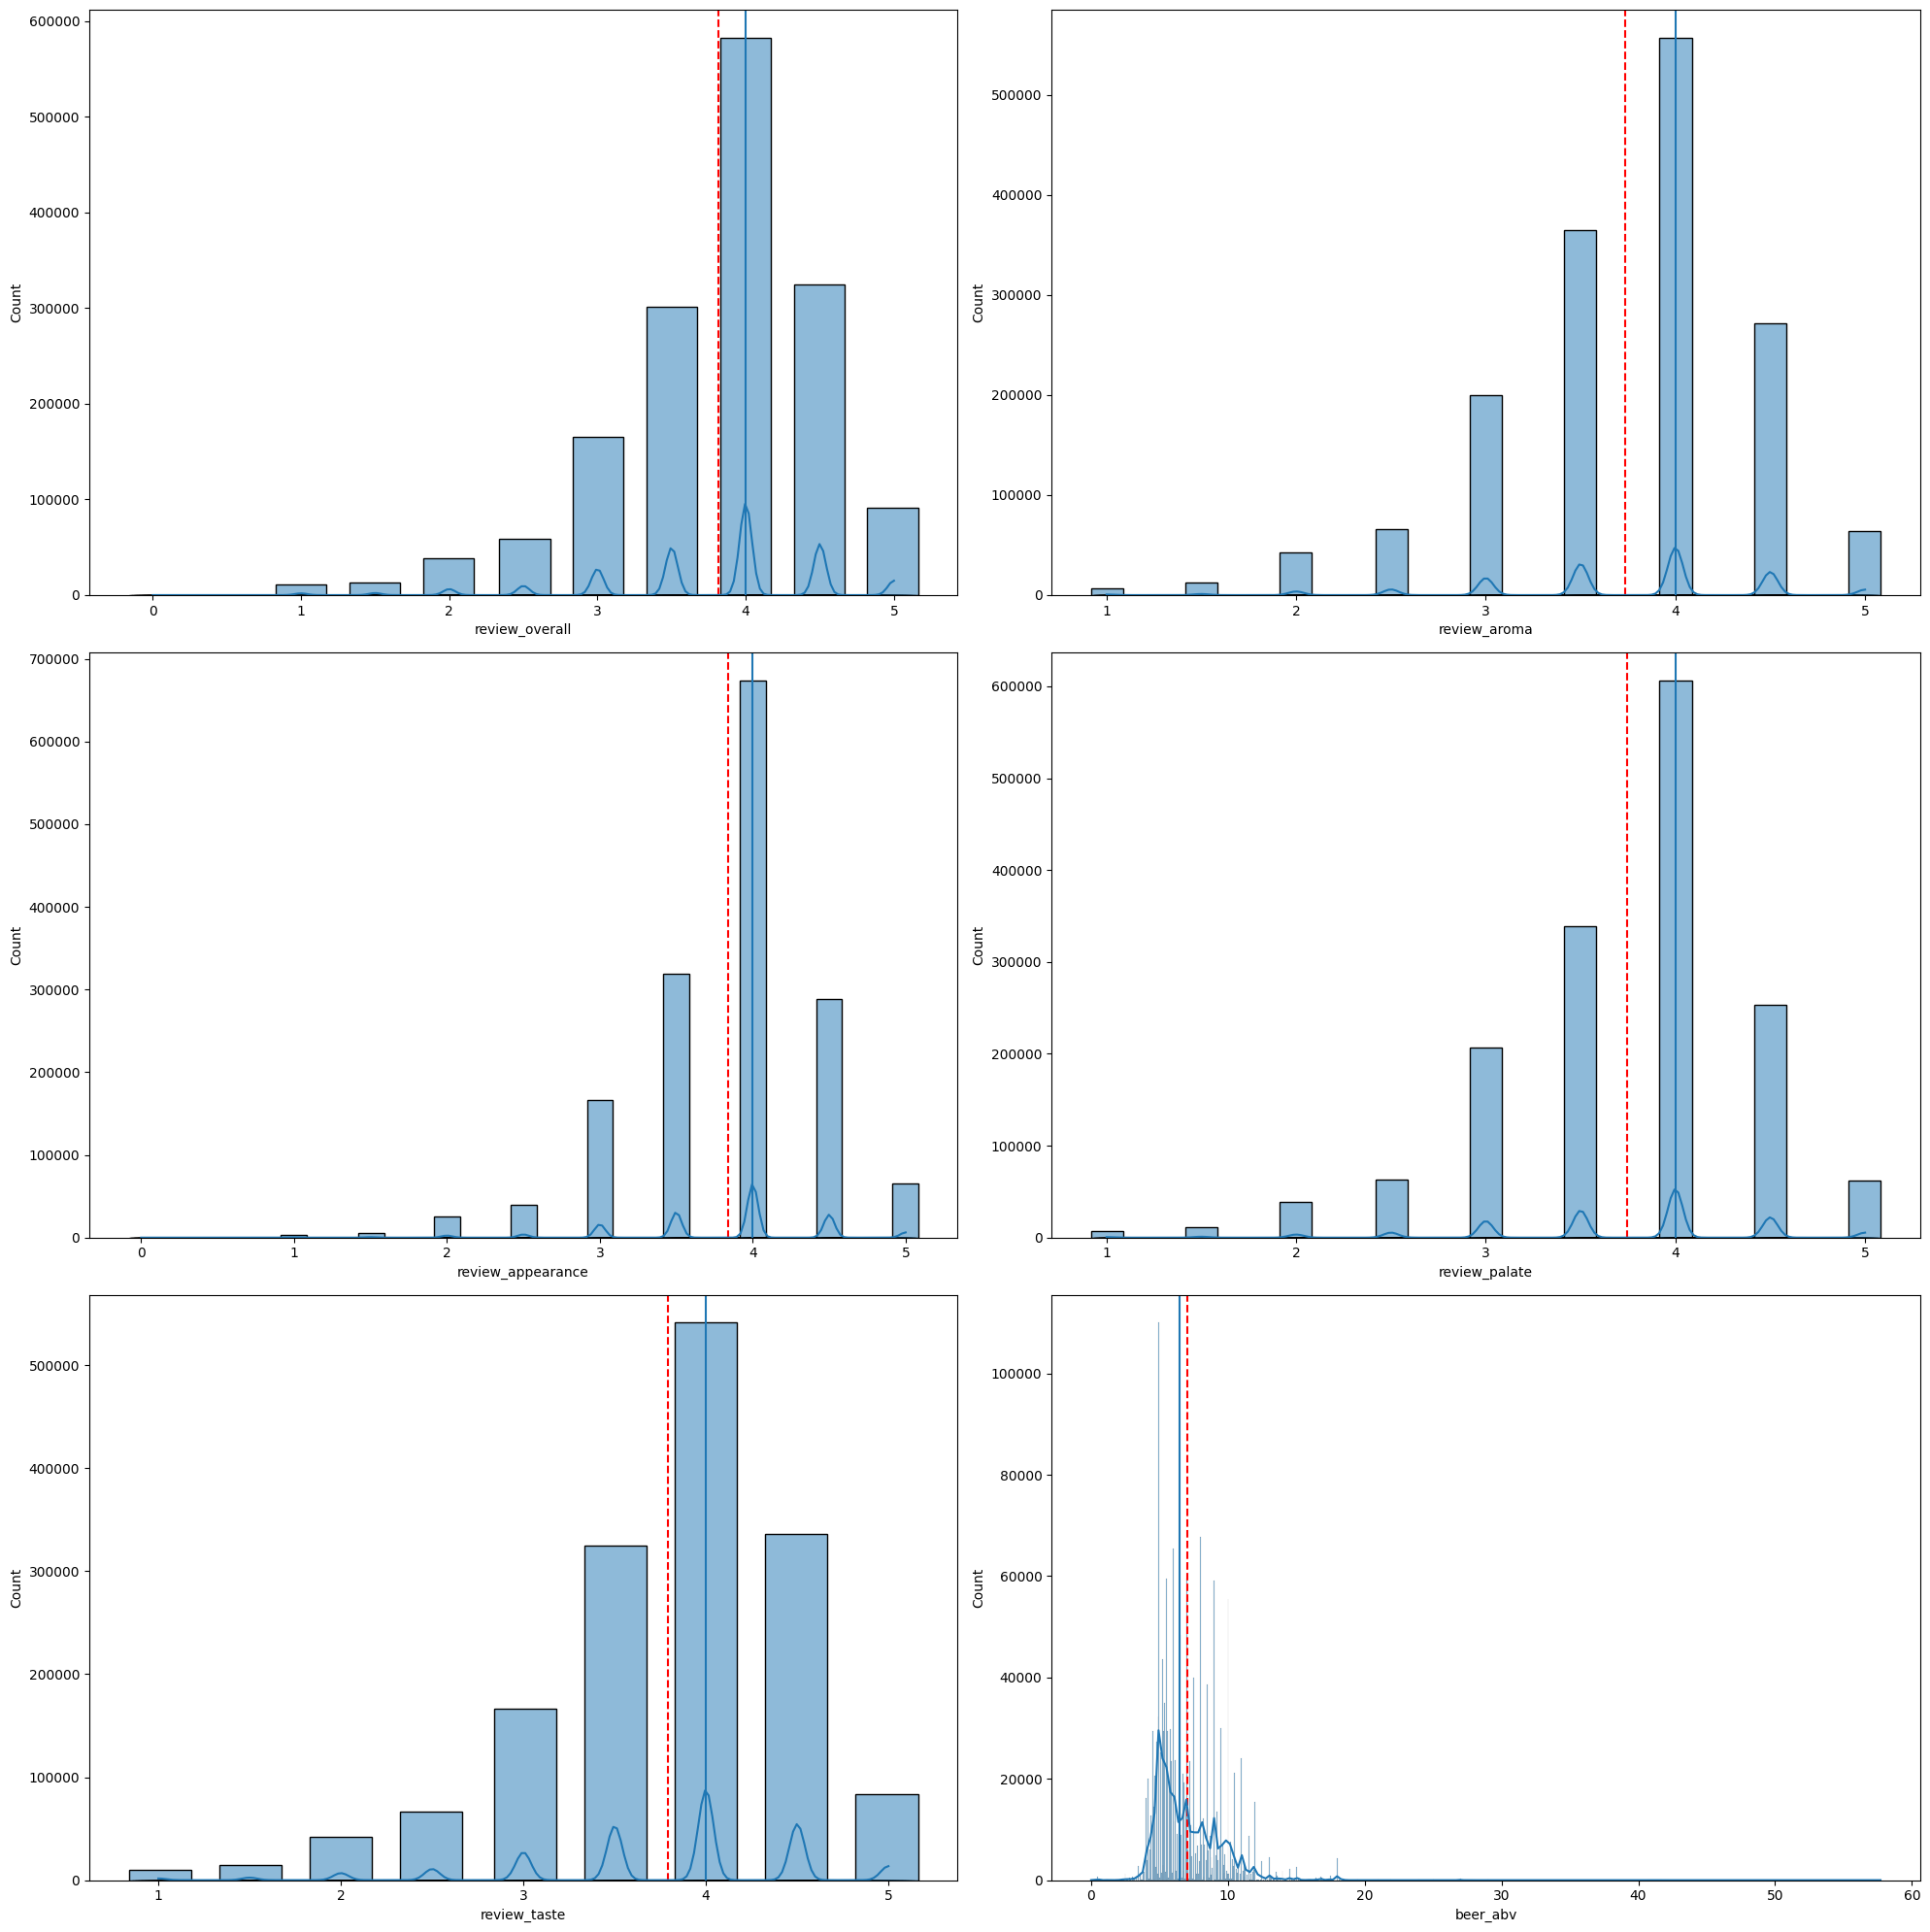

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(20,20))
axes = axes.ravel()
for col, ax in zip(df_review[numerical_features], axes):
    ax.axvline(x=df_review[col].mean(), linestyle='--', color='red')
    ax.axvline(x=df_review[col].median(), linestyle='-')
    if col == 'beer_abv':
        sns.histplot(x=df_review[col], ax=ax, kde=True)
    else:
        sns.histplot(x=df_review[col], ax=ax, kde=True,shrink=20)
plt.tight_layout()
plt.show()

In [ ]:
df_review.columns

Index(['brewery_id', 'review_overall', 'review_aroma', 'review_appearance',
       'review_profilename', 'beer_style', 'review_palate', 'review_taste',
       'beer_abv', 'beer_beerid', 'category', 'subcategory'],
      dtype='object')

Observamos que el proveedor de la cerveza no afecta al score del review.

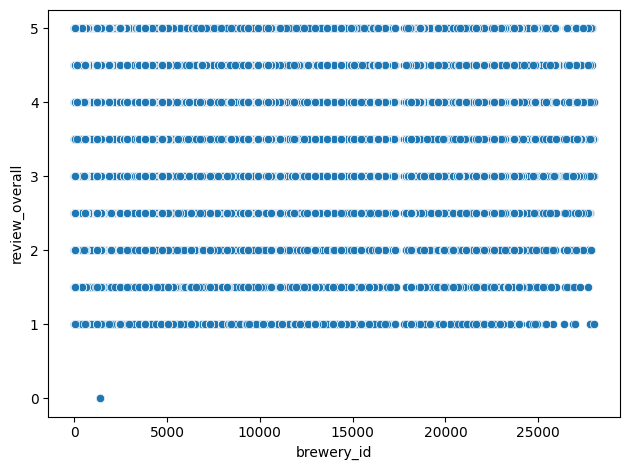

In [ ]:
sns.scatterplot(x='brewery_id',y='review_overall',data=df_review)
plt.tight_layout()
plt.show()

Observamos que si varia un poco el review por categoria o subcategoria

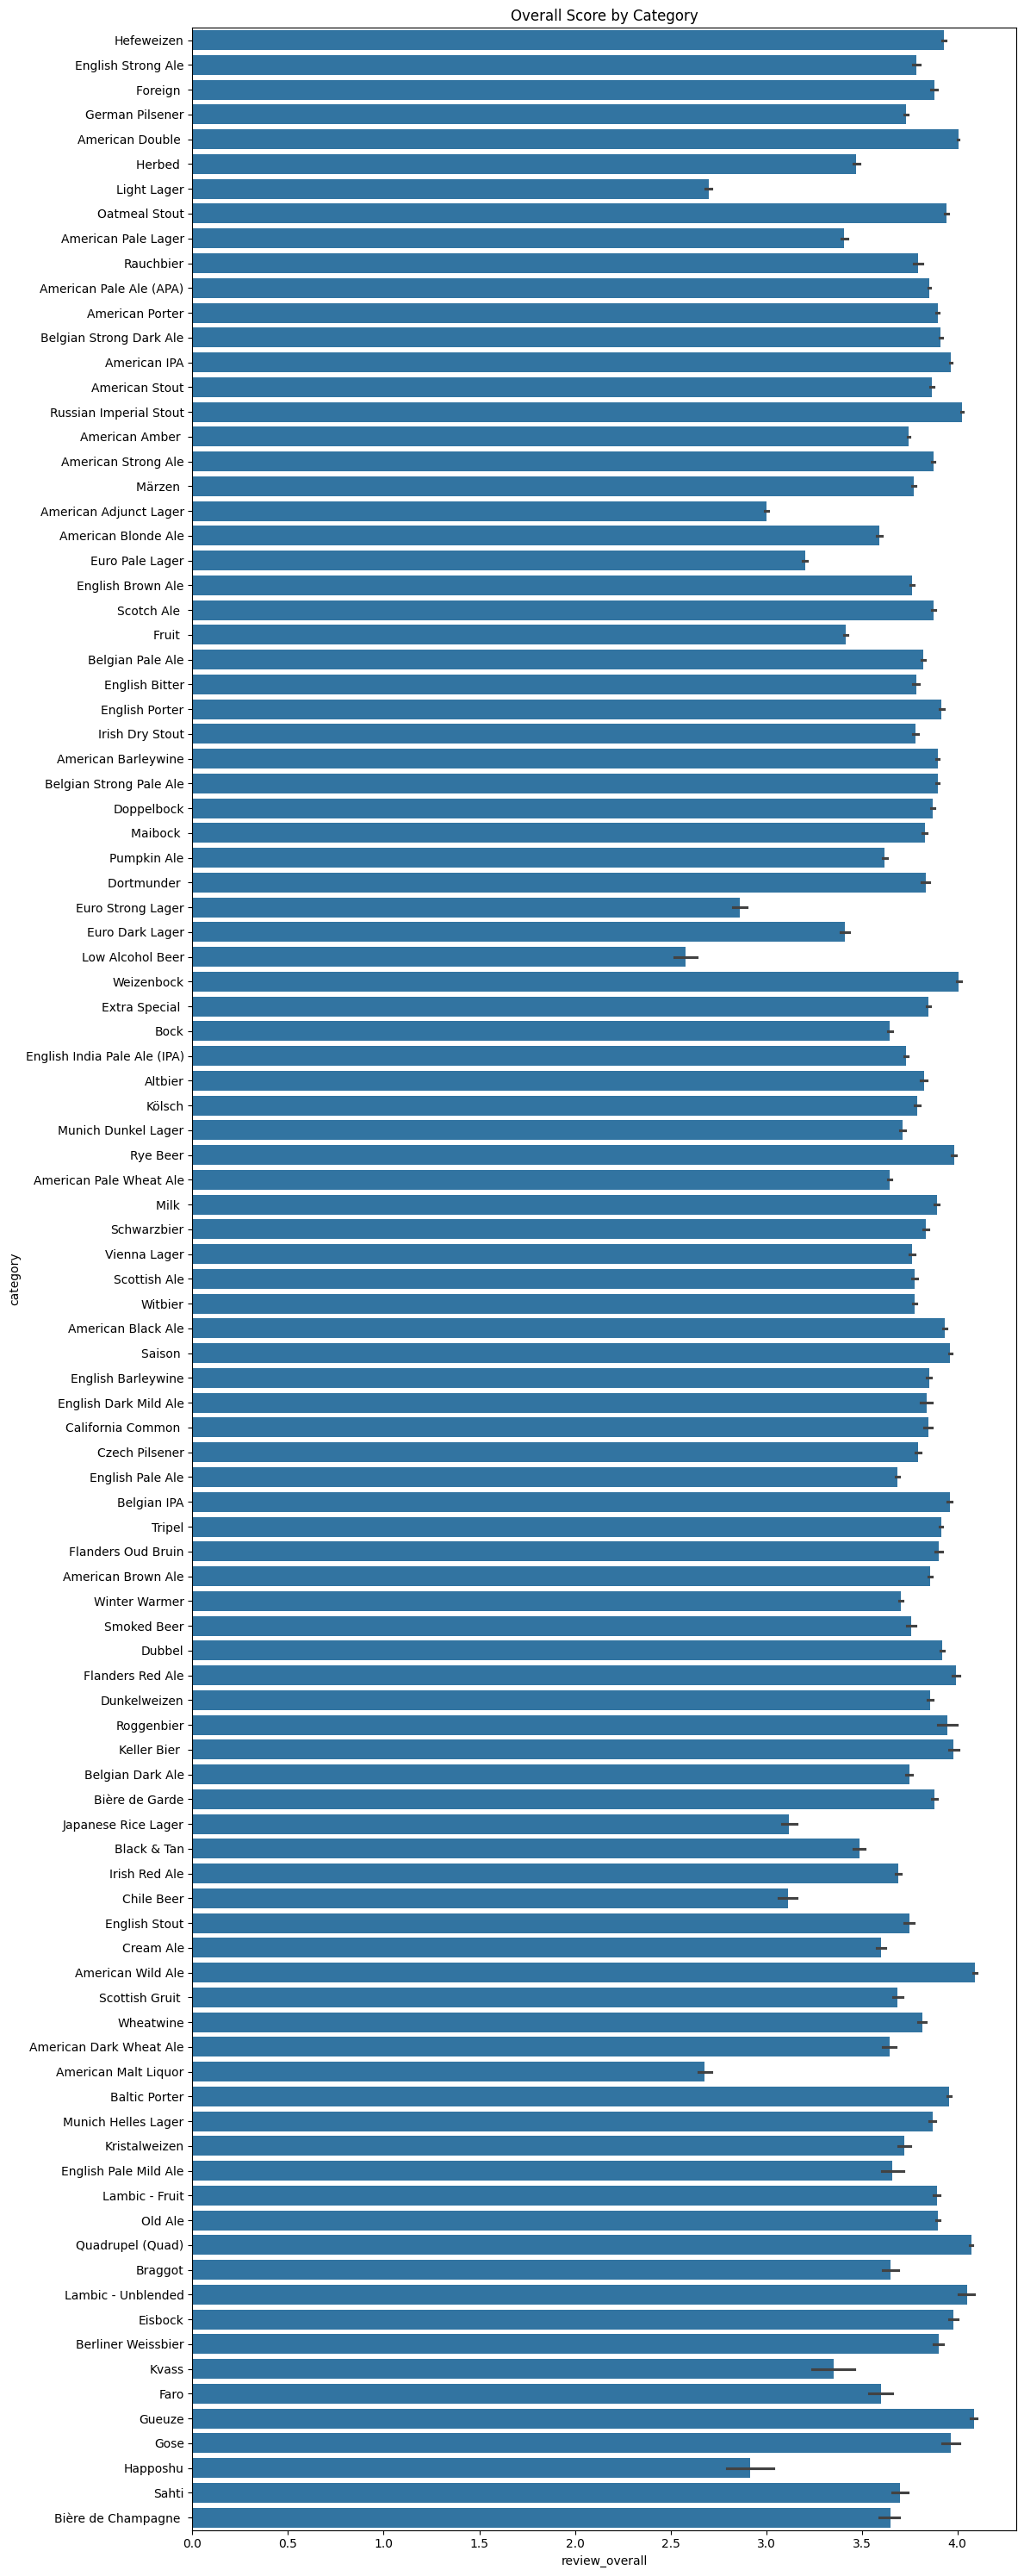

In [ ]:
plt.figure(figsize=(12,30))
sns.barplot(y=df_review['category'],x=df_review['review_overall'],data=df_review)
plt.title('Overall Score by Category')
plt.tight_layout()
plt.show()

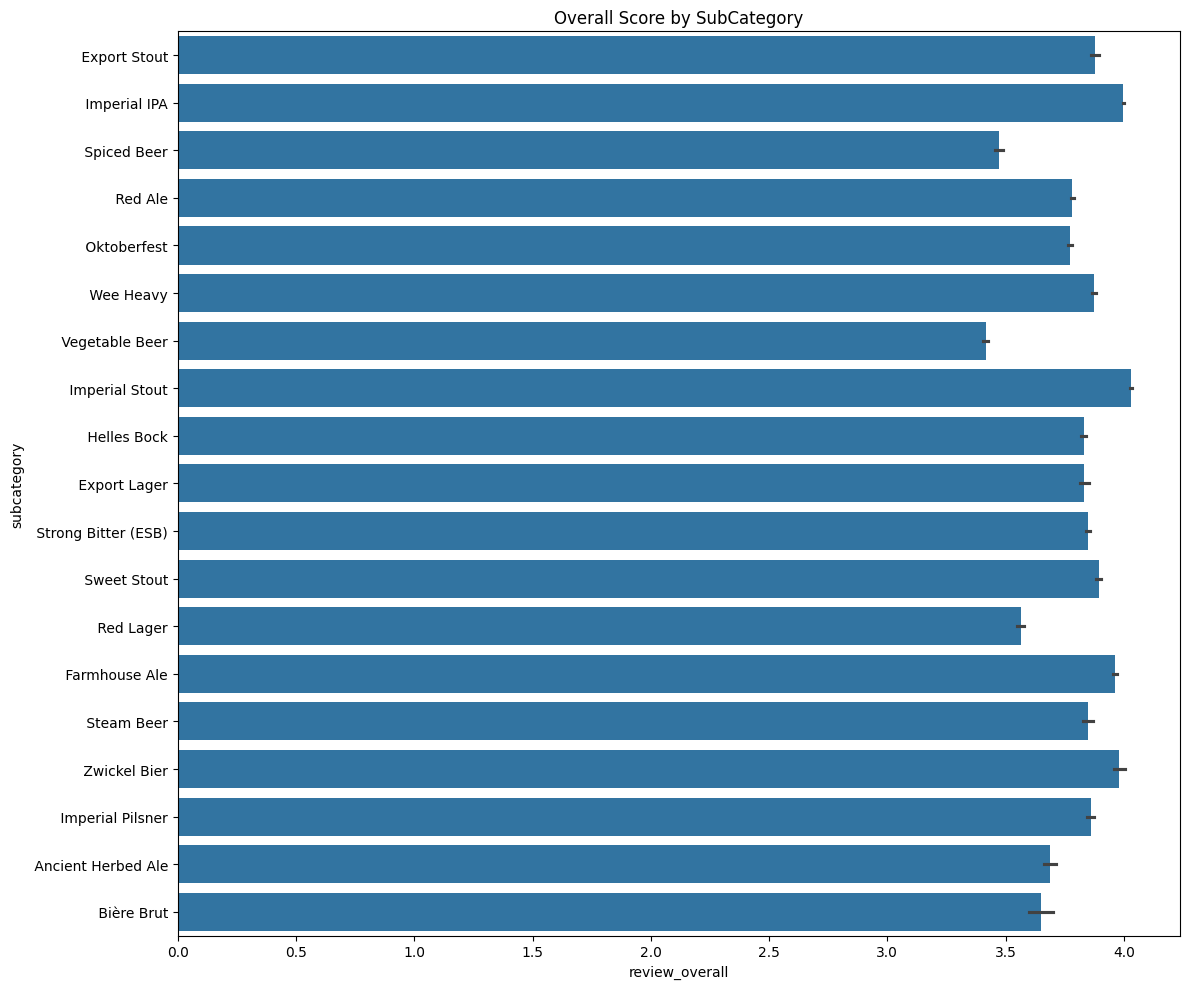

In [ ]:
plt.figure(figsize=(12,10))
sns.barplot(y=df_review['subcategory'],x=df_review['review_overall'],data=df_review)
plt.title('Overall Score by SubCategory')
plt.tight_layout()
plt.show()

23740 Cervezas de nuestro set de datos solo contiene 1 review, lo que viene siendo aproximadamente un 30% de las cervezas que tenemos. Mientras que el promedio de reviews por cerveza son 24 y su mediana 2.

In [ ]:
beers = df_review['beer_beerid'].value_counts().to_frame().reset_index()

In [ ]:
beers['count'].mean()

24.019589735826205

In [ ]:
beers['count'].median()

2.0

In [ ]:
beers[beers['count'] ==1]

,beer_beerid,count
42315,54375,1
42316,23567,1
42317,38457,1
42318,62325,1
42319,55586,1
...,...,...
66050,12708,1
66051,70915,1
66052,21441,1
66053,62863,1


De igual forma de los usuarios un 30% de ellos solo ha dejado un review. El promedio de reviews por usuario son 47 y su mediana 3.

In [ ]:
usuarios = df_review['review_profilename'].value_counts().to_frame().reset_index()

In [ ]:
usuarios['count'].mean()

47.511486506724175

In [ ]:
usuarios['count'].median()

3.0

In [ ]:
usuarios[usuarios['count'] ==1]

,review_profilename,count
22944,theycallmstacy,1
22945,Djkraz,1
22946,Addicted2Hops,1
22947,JoshuaWicked,1
22948,klh70,1
...,...,...
33382,fnong2,1
33383,drewzline,1
33384,amandacrane,1
33385,mymasterpiece75,1


Datos Finales para usar en el modelo

In [ ]:
df_review

,brewery_id,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_abv,beer_beerid,category,subcategory
0,10325,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,5.0,47986,Hefeweizen,None
1,10325,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,6.2,48213,English Strong Ale,None
2,10325,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,6.5,48215,Foreign,Export Stout
3,10325,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,5.0,47969,German Pilsener,None
4,1075,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,7.7,64883,American Double,Imperial IPA
...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,14359,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,5.2,33061,Pumpkin Ale,None
1586610,14359,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,5.2,33061,Pumpkin Ale,None
1586611,14359,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,5.2,33061,Pumpkin Ale,None
1586612,14359,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,5.2,33061,Pumpkin Ale,None


# **Sistemas de recomendacion**

Acontinuacion implementaremos un sistema de recomendacion donde dada un cerveza x, te recomendara cervezas similares. Para el preprocesamiento del modelo se elimaran todas las cervezas que solo tienen menos del promedio de reviews (esto dado que luego el modelo se vuelve muy pesado y tardado en computadoras personales), se promediaran los reviews de un usuario a una misma cerveza para generar la matriz y tambien se quitaran los usuarios que tengan menor al promedio de reviews.

In [ ]:
df_model = df_review[df_review['beer_beerid'].isin(beers[beers['count'] >= 24]['beer_beerid'])]
df_model = df_model[df_model['review_profilename'].isin(usuarios[usuarios['count'] >= 47]['review_profilename'])]
df_model

,brewery_id,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_abv,beer_beerid,category,subcategory
10,163,3.0,2.0,3.0,fodeeoz,Light Lager,2.5,2.5,3.5,436,Light Lager,None
18,163,2.5,3.0,3.0,jdhilt,Light Lager,2.0,2.0,3.5,436,Light Lager,None
19,1075,4.5,4.5,3.0,UCLABrewN84,Rauchbier,4.0,4.5,7.4,58046,Rauchbier,None
20,1075,4.0,4.0,4.0,zaphodchak,Rauchbier,3.0,4.0,7.4,58046,Rauchbier,None
21,1075,4.0,4.5,4.0,Tilley4,Rauchbier,3.5,4.0,7.4,58046,Rauchbier,None
...,...,...,...,...,...,...,...,...,...,...,...,...
1586469,14359,4.0,3.5,4.0,mnj21655,Tripel,4.0,4.0,9.0,43008,Tripel,None
1586470,14359,3.5,3.0,4.5,goatgoat,Tripel,4.0,3.5,9.0,43008,Tripel,None
1586472,14359,4.0,4.0,4.0,brewandbbq,Tripel,4.0,4.0,9.0,43008,Tripel,None
1586473,14359,3.5,3.5,4.0,Nickls,Tripel,4.0,3.5,9.0,43008,Tripel,None


In [ ]:
#Hacemos la codificacion de los nombres para tener numeros enteros
encoder = LabelEncoder()
encoder.fit(df_model['review_profilename'])
df_model['user_id'] = encoder.transform(df_model['review_profilename'])


In [ ]:
#generamos la matriz de cerveza/usuario
beer_mat = df_model.groupby(['user_id','beer_beerid'],as_index=False).agg({'review_overall':'mean'}).pivot(index='beer_beerid',columns='user_id',values='review_overall')
beer_mat.fillna(0,inplace=True)

In [ ]:
beer_mat

user_id,0,1,2,3,4,5,6,7,8,9,...,4921,4922,4923,4924,4925,4926,4927,4928,4929,4930
beer_beerid,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nc_overall = 4930

# Inicializamos y aplicamos la factorización SVD en relación a la
# evaluación de la cerveza, para determinar la cantidad de componentes
# que podemos utilizar con un 90% de explicación de la variabilidad
# de dichas componentes:

SVD_beer = TruncatedSVD( n_components = nc_overall )
SVD_beer.fit(beer_mat)

# Determinemos la cantidad de componentes que explican un 90%
# de la variabilidad acumulada de cada componente:

for j in range(nc_overall):
  if SVD_beer.explained_variance_ratio_[0:j].sum() > 0.90:
    break

# Usaremos esta cantidad de componentes para las recomendaciones basadas
# en la calificación de la cerveza:
N_beer = j-1

print('Total de valores singulares basados en evaluación de la :', nc_overall)
print('Valor de truncamiento al 90% de dicha variabilidad:',N_beer)

Total de valores singulares basados en evaluación de la : 4930
Valor de truncamiento al 90% de dicha variabilidad: 1491


In [ ]:
# Usando la métrica de correlación de Pearson, obtendremos las 10 mejores
# recomendaciones de este modelo no supervisado con base a la información de
# alguien que desea obtener las similidades.
# Para ello obtendremos las correlaciones positivas y de ahí deberás seleccionar
# las diez mejores.

# Factorización SVD:
SVD_beer = TruncatedSVD(n_components = N_beer)
resultant_matrix_beer = SVD_beer.fit_transform(beer_mat)

# Matriz de correlación de Pearson:
corr_mat_beer = np.corrcoef(resultant_matrix_beer)

In [ ]:
# Cerveza de referencia:
cerveza_de_referencia = 58046
nombres_beer = beer_mat.T.columns  # nombres de restaurantes
idx_rest = list(nombres_beer).index(cerveza_de_referencia)
corr_rest = corr_mat_beer[idx_rest] # Vector de Correlación del RinconHuasteco

# Buscando las correlaciones positivas:
idx = (corr_rest>0)
mejores_sim_beer = list()
for i in range(len(nombres_beer[idx])):
  mejores_sim_beer.append((corr_rest[idx][i], nombres_beer[idx][i]))

print('Total de similaridades positivas encontradas:', len(mejores_sim_beer))

mejores_sim_beer.sort(key=lambda a:a[0],reverse=True)
# Desplegamos las 10 mejores similitudes encontradas de manera descendente:
print('Similitudes con base a la evaluación de la comida con mayores valores de correlación:')
for k in range(1,11):
  print('%d> %s' % (k, mejores_sim_beer[k]))

Total de similaridades positivas encontradas: 7701
Similitudes con base a la evaluación de la comida con mayores valores de correlación:
1> (0.3105228851491044, 56071)
2> (0.2755149444331699, 20818)
3> (0.27545272897153267, 56757)
4> (0.2748519513788093, 49634)
5> (0.27152773465462876, 65945)
6> (0.26909516041050846, 43716)
7> (0.2636199872684732, 63167)
8> (0.250562961966395, 35609)
9> (0.24784840511269587, 57951)
10> (0.24759830560295013, 76525)


In [ ]:
def comparar(idbuscado,idmatch):
    info_buscado = df_review[df_review['beer_beerid'] == idbuscado]
    review_overall_idbuscado = info_buscado['review_overall'].mean()
    review_aroma_idbuscado = info_buscado['review_aroma'].mean()
    review_appearance_idbuscado = info_buscado['review_appearance'].mean()
    review_palate_idbuscado = info_buscado['review_palate'].mean()
    review_taste_idbuscado = info_buscado['review_taste'].mean()
    beer_style_buscado = info_buscado['brewery_id'].unique()[0]

    info_match = df_review[df_review['beer_beerid'] == idmatch]
    review_overall_match = info_match['review_overall'].mean()
    review_aroma_match = info_match['review_aroma'].mean()
    review_appearance_match = info_match['review_appearance'].mean()
    review_palate_match = info_match['review_palate'].mean()
    review_taste_match = info_match['review_taste'].mean()
    beer_style_match = info_match['brewery_id'].unique()[0]

    print('Datos de la cerveza buscada: ',idbuscado)
    print('Promedio Overall Review: ', review_overall_idbuscado)
    print('Promedio Aroma Review: ', review_aroma_idbuscado)
    print('Promedio Appearance Review: ', review_appearance_idbuscado)
    print('Promedio Palate Review: ', review_palate_idbuscado)
    print('Promedio Taste Review: ', review_taste_idbuscado)
    print('Estilo: ', beer_style_buscado)

    print()

    print('Datos de la cerveza que hizo match: ',idmatch)
    print('Promedio Overall Review: ', review_overall_match)
    print('Promedio Aroma Review: ', review_aroma_match)
    print('Promedio Appearance Review: ', review_appearance_match)
    print('Promedio Palate Review: ', review_palate_match)
    print('Promedio Taste Review: ', review_taste_match)
    print('Estilo: ', beer_style_match)

In [ ]:
comparar(58046,56071)

Datos de la cerveza buscada:  58046
Promedio Overall Review:  4.166666666666667
Promedio Aroma Review:  4.309523809523809
Promedio Appearance Review:  3.8214285714285716
Promedio Palate Review:  3.892857142857143
Promedio Taste Review:  4.154761904761905
Estilo:  1075

Datos de la cerveza que hizo match:  56071
Promedio Overall Review:  3.5689655172413794
Promedio Aroma Review:  3.456896551724138
Promedio Appearance Review:  4.0
Promedio Palate Review:  3.706896551724138
Promedio Taste Review:  3.5775862068965516
Estilo:  1075


# **Conclusiones**

Como podemos observar en el ejemplo, con el sistema de recomendacion que se genero en base a solo el review general de la cerveza notamos que no tuvo un valor alto de correlacion, apenas un 30% y vemos bastante variacion entre algunas de las caracteristicas por lo tanto como mejora podria ser basar el sistema de recomendacion para una caracteristica en especial dado que el review general ya es un promedio entre las caracteristicas y podemos perder informacion por usar esta metrica. Asi que se podria hacer un sistema de recomendacion para las caracteristicas deseadas para asi encontrar similitudes mas exactas.